In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image


In [3]:
import shutil
import os

# Existing dataset (already in Drive)
OLD_DATASET = "/content/drive/MyDrive/cat_species_dataset"

# New project structure
BASE_DIR = "/content/drive/MyDrive/Cat_Species_CNN_Lab"
NEW_DATASET = f"{BASE_DIR}/original_dataset/cat_species_dataset"

# Create folders
os.makedirs(f"{BASE_DIR}/original_dataset", exist_ok=True)

# Copy dataset
if not os.path.exists(NEW_DATASET):
    shutil.copytree(OLD_DATASET, NEW_DATASET)
    print("✅ Dataset copied into project folder")
else:
    print("ℹ️ Dataset already exists in project folder")


✅ Dataset copied into project folder


In [4]:
AUGMENTED_DATASET = f"{BASE_DIR}/augmented_dataset"
MODEL_SAVE_PATH = f"{BASE_DIR}/models/custom_cnn_cat_species.pth"

os.makedirs(AUGMENTED_DATASET, exist_ok=True)
os.makedirs(f"{BASE_DIR}/models", exist_ok=True)


// data agumentation


In [10]:

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3
    )
])

TARGET_IMAGES_PER_SPECIES = 100

for species in os.listdir(NEW_DATASET):
    src_folder = os.path.join(NEW_DATASET, species)
    dst_folder = os.path.join(AUGMENTED_DATASET, species)
    os.makedirs(dst_folder, exist_ok=True)

    original_images = [
        img for img in os.listdir(src_folder)
        if img.endswith(".png")
    ]

    # 1️⃣ Save original images first
    for img_name in original_images:
        image = Image.open(os.path.join(src_folder, img_name)).convert("RGB")
        image.save(os.path.join(dst_folder, img_name))

    current_count = len(original_images)
    aug_index = 0

    # 2️⃣ Generate augmented images until ~100 reached
    while current_count < TARGET_IMAGES_PER_SPECIES:
        img_name = original_images[aug_index % len(original_images)]
        image = Image.open(os.path.join(src_folder, img_name)).convert("RGB")

        aug_img = augment_transform(image)
        aug_img.save(
            os.path.join(dst_folder, f"aug_{current_count+1}.png")
        )

        current_count += 1
        aug_index += 1

    print(f"{species}: total images = {current_count}")


Abyssinian_cat: total images = 100
American_Bobtail_cat: total images = 100
American_Curl_cat: total images = 100
American_Shorthair_cat: total images = 100
American_Wirehair_cat: total images = 100
Balinese_cat: total images = 100
Bengal_cat: total images = 100
Birman_cat: total images = 100
Bombay_cat: total images = 100
British_Shorthair_cat: total images = 100
Burmese_cat: total images = 100
Chartreux_cat: total images = 100
Cornish_Rex_cat: total images = 100
Devon_Rex_cat: total images = 100
Egyptian_Mau_cat: total images = 100
Exotic_Shorthair_cat: total images = 100
Havana_Brown_cat: total images = 100
Himalayan_cat: total images = 100
Japanese_Bobtail_cat: total images = 100
Korat_cat: total images = 100
LaPerm_cat: total images = 100
Maine_Coon_cat: total images = 100
Manx_cat: total images = 100
Norwegian_Forest_cat: total images = 100
Ocicat_cat: total images = 100
Oriental_Shorthair_cat: total images = 100
Persian_cat: total images = 100
Ragdoll_cat: total images = 100
Rus

In [11]:
# Transform for training CNN
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(
    root=AUGMENTED_DATASET,
    transform=transform
)

class_names = dataset.classes
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Total images:", len(dataset))


Number of classes: 40
Total images: 6000


In [12]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Training samples: 4800
Validation samples: 1200


In [13]:
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [14]:
model = CustomCNN(num_classes).to("cuda")
print(model)


CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=40, bias=True)
  )
)


In [15]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
from tqdm import tqdm


In [18]:
epochs = 25

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs}",
        leave=True
    )

    for images, labels in progress_bar:
        images, labels = images.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # update progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1} completed | Avg Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/25: 100%|██████████| 150/150 [00:41<00:00,  3.59it/s, loss=1]


✅ Epoch 1 completed | Avg Loss: 1.2951


Epoch 2/25: 100%|██████████| 150/150 [00:41<00:00,  3.65it/s, loss=0.299]


✅ Epoch 2 completed | Avg Loss: 0.4430


Epoch 3/25: 100%|██████████| 150/150 [00:41<00:00,  3.65it/s, loss=0.338]


✅ Epoch 3 completed | Avg Loss: 0.1765


Epoch 4/25: 100%|██████████| 150/150 [00:41<00:00,  3.66it/s, loss=0.166]


✅ Epoch 4 completed | Avg Loss: 0.1237


Epoch 5/25: 100%|██████████| 150/150 [00:40<00:00,  3.67it/s, loss=0.159]


✅ Epoch 5 completed | Avg Loss: 0.1313


Epoch 6/25: 100%|██████████| 150/150 [00:40<00:00,  3.67it/s, loss=0.149]


✅ Epoch 6 completed | Avg Loss: 0.1511


Epoch 7/25: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s, loss=0.0208]


✅ Epoch 7 completed | Avg Loss: 0.1283


Epoch 8/25: 100%|██████████| 150/150 [00:41<00:00,  3.63it/s, loss=0.00904]


✅ Epoch 8 completed | Avg Loss: 0.0944


Epoch 9/25: 100%|██████████| 150/150 [00:40<00:00,  3.67it/s, loss=0.162]


✅ Epoch 9 completed | Avg Loss: 0.0875


Epoch 10/25: 100%|██████████| 150/150 [00:41<00:00,  3.66it/s, loss=0.182]


✅ Epoch 10 completed | Avg Loss: 0.0881


Epoch 11/25: 100%|██████████| 150/150 [00:40<00:00,  3.67it/s, loss=0.118]


✅ Epoch 11 completed | Avg Loss: 0.0878


Epoch 12/25: 100%|██████████| 150/150 [00:41<00:00,  3.66it/s, loss=0.000163]


✅ Epoch 12 completed | Avg Loss: 0.0872


Epoch 13/25: 100%|██████████| 150/150 [00:41<00:00,  3.65it/s, loss=0.0712]


✅ Epoch 13 completed | Avg Loss: 0.0872


Epoch 14/25: 100%|██████████| 150/150 [00:41<00:00,  3.64it/s, loss=0.0832]


✅ Epoch 14 completed | Avg Loss: 0.0859


Epoch 15/25: 100%|██████████| 150/150 [00:41<00:00,  3.65it/s, loss=0.139]


✅ Epoch 15 completed | Avg Loss: 0.0885


Epoch 16/25: 100%|██████████| 150/150 [00:41<00:00,  3.63it/s, loss=2.19e-5]


✅ Epoch 16 completed | Avg Loss: 0.0854


Epoch 17/25: 100%|██████████| 150/150 [00:40<00:00,  3.66it/s, loss=0.0687]


✅ Epoch 17 completed | Avg Loss: 0.0850


Epoch 18/25: 100%|██████████| 150/150 [00:40<00:00,  3.67it/s, loss=0.0917]


✅ Epoch 18 completed | Avg Loss: 0.0857


Epoch 19/25: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s, loss=0.151]


✅ Epoch 19 completed | Avg Loss: 0.0855


Epoch 20/25: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s, loss=0.0381]


✅ Epoch 20 completed | Avg Loss: 0.0854


Epoch 21/25: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s, loss=6.46e-5]


✅ Epoch 21 completed | Avg Loss: 0.0849


Epoch 22/25: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s, loss=0.0306]


✅ Epoch 22 completed | Avg Loss: 0.0849


Epoch 23/25: 100%|██████████| 150/150 [00:40<00:00,  3.66it/s, loss=1.6e-5]


✅ Epoch 23 completed | Avg Loss: 0.0849


Epoch 24/25: 100%|██████████| 150/150 [00:41<00:00,  3.65it/s, loss=0.16]


✅ Epoch 24 completed | Avg Loss: 0.0845


Epoch 25/25: 100%|██████████| 150/150 [00:40<00:00,  3.66it/s, loss=0.134]

✅ Epoch 25 completed | Avg Loss: 0.0846


In [19]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to("cuda"), labels.to("cuda")

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

accuracy = (correct / total) * 100
print(f"✅ Final Validation Accuracy: {accuracy:.2f}%")


✅ Final Validation Accuracy: 91.67%


In [20]:
import torch

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("✅ Trained model saved successfully in Google Drive")


✅ Trained model saved successfully in Google Drive


In [21]:
print("\n📌 TRAINING SUMMARY")
print("----------------------------")
print("Total classes      :", num_classes)
print("Total images       :", len(dataset))
print("Final accuracy (%) :", round(accuracy, 2))
print("Model saved at     :", MODEL_SAVE_PATH)



📌 TRAINING SUMMARY
----------------------------
Total classes      : 40
Total images       : 6000
Final accuracy (%) : 91.67
Model saved at     : /content/drive/MyDrive/Cat_Species_CNN_Lab/models/custom_cnn_cat_species.pth


Saving ragdoll_cat.jpg to ragdoll_cat (1).jpg


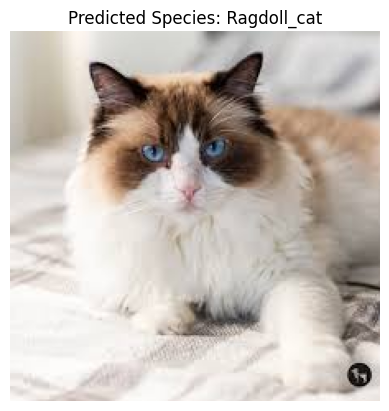

🧠 Model Prediction: Ragdoll_cat


In [27]:
# ===== Upload Google Image & Predict =====

import torch
from google.colab import files
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 1️⃣ Upload image using Colab UI
uploaded = files.upload()

# 2️⃣ Load trained model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

# 3️⃣ Define transform (same as training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 4️⃣ Get uploaded image
image_name = list(uploaded.keys())[0]
image_path = f"/content/{image_name}"

image = Image.open(image_path).convert("RGB")
image_tensor = test_transform(image).unsqueeze(0).to("cuda")

# 5️⃣ Predict
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)

predicted_class = class_names[predicted.item()]

# 6️⃣ Show result
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted Species: {predicted_class}")
plt.show()

print("🧠 Model Prediction:", predicted_class)
